In [1]:
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)


def reset_network(p):
    random.seed(42)

    inputlayer = ShapedLayer((8,8))
    foldiaklayer = ShapedLayer(16)

    foldiaklayer.fillnodes(FoldiakNode)
    inputlayer.fillnodes(InputNode)

    network = FoldiakShapedNet()
    network.append(inputlayer)
    network.append(foldiaklayer)
    network.connect_foldiak(inputlayer, foldiaklayer)

    network.setparam("a",0.1)
    network.setparam("b",0.02)
    network.setparam("y",0.02)
    network.setparam("p",p)
    network.setparam("l",10)
    network.setparam("intmethod","LSODA")
    network.setparam("tmax",100)
    
    return inputlayer, foldiaklayer, network

In [2]:
samples = np.loadtxt("../data/lines_keyed.csv")
keys = np.loadtxt("../data/lines_keys.csv")

possibletypes = []
for i in range(8):
    sample = np.zeros((8,8))
    sample[i,:] = 1
    possibletypes.append(sample)
for i in range(8):
    sample = np.zeros((8,8))
    sample[:,i] = 1
    possibletypes.append(sample)

key_errors = []

In [3]:
inputlayer, foldiaklayer, network = reset_network(0.025)

In [4]:
#setup code: the two network.update calls handle numba jit compilations.
def net_reset(p):
    network.setup()
    network.setup()
    #Steady state thres:
    network.setparam("a",0.0)
    network.setparam("b",0.0)
    network.setparam("y",0.5)
    for i in range(200):
        for i in inputlayer.nodes:
            i.setvalstored(random.uniform(0,1))
        network.update()
    network.setparam("a",0.1)
    network.setparam("b",0.02)
    network.setparam("y",0.02)

def timenet(nbefore, nafter):
    for i in range(nbefore):
        inputlayer.setvals(samples[i,:])
        network.update()
    permutation = [0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0]
    outimages = []

    for j in range(16):
        lowestmin = 64
        outimage = np.zeros((8,8))
        goestonum = 0
        tnum = 0
        for i in possibletypes:
            mem = np.reshape(network.cgroups[0].getbiases()[:,j],(8,8))
            mem = mem/mem.max()
            er = np.sum(np.abs(mem - i))
            #print(er)
            if (er < lowestmin):
                lowestmin = er
                outimage = np.abs(mem-i)
                goestonum = tnum
            tnum += 1
        outimages.append(outimage)
        permutation[goestonum] = j
        
    
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    
    output_keys = np.zeros((nafter,16))
    
    test_keys_this = keys[nbefore:nbefore+nafter, idx]
    test_samples_this = samples[nbefore:nbefore+nafter]
    
    for i in range(nafter):
        inputlayer.setvals(test_samples_this[i,:])
        network.update()
        output_keys[i,:] = foldiaklayer.returnvals()

    key_errors.append(np.sum(np.abs(test_keys_this-output_keys))/np.sum(test_keys_this))

In [5]:
#ps go from 0.025 to 0.350, by 0.025
ps = [0.000, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200, 0.225, 0.250, 0.275, 0.300, 0.325, 0.350]

In [6]:
for i in ps:
    inputlayer, foldiaklayer, network = reset_network(i)
    net_reset(i)
    timenet(40000, 5000)
    print("Finished testing: "+str(i))

Finished testing: 0.0
Finished testing: 0.025
Finished testing: 0.05
Finished testing: 0.075
Finished testing: 0.1
Finished testing: 0.125
Finished testing: 0.15
Finished testing: 0.175
Finished testing: 0.2
Finished testing: 0.225
Finished testing: 0.25
Finished testing: 0.275
Finished testing: 0.3
Finished testing: 0.325
Finished testing: 0.35


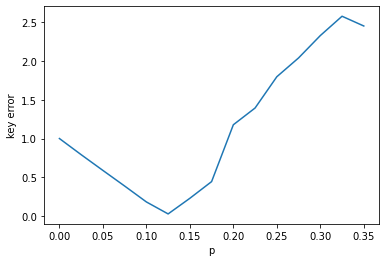

In [7]:
plt.plot(ps, key_errors)
plt.xlabel("p")
plt.ylabel("key error")
plt.savefig("images/2020_07_14_LEB_key_error_v_p")
plt.show()

In [11]:
key_errors

[0.7915599713202909,
 0.38686879033084093,
 0.026938441052955033,
 0.44402335347741473,
 1.3054076198279394,
 1.8708920187793427,
 2.439873739945016]

In [13]:
plt.imshow((test_keys_this-output_keys)[:100,:])
plt.show()

print(np.sum(output_keys)/16000)
print(np.sum(test_keys_this)/16000)

NameError: name 'test_keys_this' is not defined

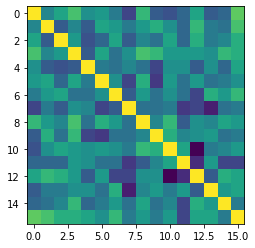

In [14]:
plt.imshow(network.cgroups[1].getbiases())
plt.show()

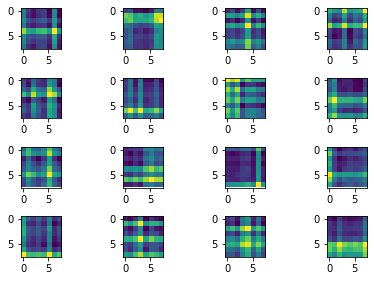

In [15]:
fig=plt.figure()

for node_num in range(len(foldiaklayer.nodes)):
    testbias = []
    connects = np.reshape(network.cgroups[0].npconnects, -1)
    for node in inputlayer.nodes:
        for i in connects:
            if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                testbias.append(i.bias)
    fig.add_subplot(4,4,node_num+1)
            
    plt.imshow(np.array(testbias).reshape((8,8)))
fig.tight_layout()
plt.show()